In [1]:
from transformers import Trainer,get_linear_schedule_with_warmup,RobertaTokenizer,BertForSequenceClassification,BitsAndBytesConfig
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import psutil
from sklearn.model_selection import train_test_split
from peft import prepare_model_for_kbit_training
from peft import get_peft_model
import time
from collections import defaultdict
import math

In [2]:
def print_trainable_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable:,}")
    print(f"Total parameters: {total:,}")
    print(f"Percentage of trainable params: {100 * trainable / total:.2f}%")

## Custom RoBERTa class needs work

In [3]:
import torch
import torch.nn as nn
from transformers import RobertaForSequenceClassification

class RobertaForSequenceClassificationWithCustomHead(RobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        # Add a new custom layer, e.g., a small MLP after the original classifier
        self.custom_layer = nn.Sequential(
            nn.Linear(config.num_labels, 64),
            nn.ReLU(),
            nn.Linear(64, config.num_labels)
        )
    
    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):

        # Remove any unexpected keys that RobertaForSequenceClassification won't accept
        accepted_keys = {"input_ids", "attention_mask", "labels", "token_type_ids", "position_ids", "head_mask", "inputs_embeds", "output_attentions", "output_hidden_states", "return_dict"}
        filtered_kwargs = {k: v for k, v in kwargs.items() if k in accepted_keys}

        # Safe call to parent forward
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            **filtered_kwargs
        )

        logits = outputs.logits
        custom_logits = self.custom_layer(logits)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(custom_logits, labels)

        return type(outputs)(
            loss=loss,
            logits=custom_logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [4]:
class VeRALinear(nn.Module):
    def __init__(self, in_features, out_features, rank=1, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = nn.Parameter(torch.empty(out_features, in_features), requires_grad=False)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

        self.u = nn.Parameter(torch.randn(rank, out_features))
        self.v = nn.Parameter(torch.randn(rank, in_features))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        delta_w = torch.matmul(self.u.T, self.v)
        w_eff = self.weight + delta_w
        return F.linear(x, w_eff, self.bias)

In [5]:
def apply_VeRA_to_roberta(model, rank=1):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            in_f, out_f = module.in_features, module.out_features
            vera_layer = VeRALinear(in_f, out_f, rank=rank, bias=(module.bias is not None))
            vera_layer.weight.data.copy_(module.weight.data)
            if module.bias is not None:
                vera_layer.bias.data.copy_(module.bias.data)

            parent = model
            path = name.split(".")
            for part in path[:-1]:
                parent = getattr(parent, part)
            setattr(parent, path[-1], vera_layer)
    return model

In [6]:
from transformers import RobertaTokenizerFast
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassificationWithCustomHead.from_pretrained("roberta-base", num_labels=15)
model = apply_VeRA_to_roberta(model, rank=4)
print(model.config)
print_trainable_parameters(model)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Number of available GPUs: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available.")
device

# Pretrained RoBERTa tokenizer (e.g. roberta-base)
#pretrained_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# Your custom tokenizer trained on OOL tokens
custom_tokenizer = RobertaTokenizer.from_pretrained('./tokenizer') # Try to remove Fast?

Some weights of RobertaForSequenceClassificationWithCustomHead were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'custom_layer.0.bias', 'custom_layer.0.weight', 'custom_layer.2.bias', 'custom_layer.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 51

In [8]:
custom_vocab = set(custom_tokenizer.get_vocab().keys())

new_tokens = list(custom_vocab)

print(f"Found {len(new_tokens)} new tokens to use.")

Found 30522 new tokens to use.


In [9]:
model.resize_token_embeddings(len(custom_tokenizer))

Embedding(30522, 768, padding_idx=1)

In [ ]:
from peft import get_peft_model, VeraConfig, TaskType

config = VeraConfig(
    task_type=TaskType.SEQ_CLS,     # or SEQ_2_SEQ_LM, TOKEN_CLS, etc.
    r=4,
    vera_dropout=0.1,
    target_modules=["query", "key", "value"],  # Adjust for RoBERTa,
    bias="none"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)
model.to(device)

TypeError: VeraConfig.__init__() got an unexpected keyword argument 'lora_alpha'

In [ ]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

data = pd.read_pickle('./saved_data/encoded_data.pck')
le = LabelEncoder()
data['target'] = le.fit_transform(data['Attack_type'])

data = pd.read_csv(".\data\Edge-IIoTset dataset\Selected dataset for ML and DL\ML-EdgeIIoT-dataset.csv")
columns = list(data.columns[:-2])

In [ ]:
with open("column_name_encoded_data.txt","w") as f:
    for _, row in data.iterrows():
        tokens = row.split(" ")
        formatted = []
        for idx, (col, tok) in enumerate(zip(columns, tokens)):
            end_char = "." if idx == len(tokens) - 1 else ";"
            formatted.append(f"{col}: {tok}{end_char}")
        f.write(formatted)
#'<s>','<pad>','</s>','<unk>','<mask>'

In [ ]:
with open("column_name_encoded_data.txt", "r") as f:
    prompt_lines = f.readlines()

# Strip newline characters
prompt_lines = [prompt_line.strip() for prompt_line in prompt_lines]
prompt_data = {
    "encoded_PPFLE_prompt": prompt_lines, 'Attack_type': data['Attack_type'], 'Attack_label': data['Attack_label'], 'target': data['target']
}
prompt_df = pd.DataFrame(prompt_data)
prompt_df.sample(15)

,encoded_PPFLE_prompt,Attack_type,Attack_label,target
85834,You are an expert in network traffic classific...,Backdoor,1,0
13069,You are an expert in network traffic classific...,Ransomware,1,10
108098,You are an expert in network traffic classific...,Normal,0,7
59604,You are an expert in network traffic classific...,Password,1,8
88256,You are an expert in network traffic classific...,Backdoor,1,0
47250,You are an expert in network traffic classific...,DDoS_TCP,1,3
94950,You are an expert in network traffic classific...,XSS,1,14
138385,You are an expert in network traffic classific...,DDoS_UDP,1,4
110037,You are an expert in network traffic classific...,Normal,0,7
46888,You are an expert in network traffic classific...,DDoS_TCP,1,3


In [ ]:
train_set = prompt_df.sample(frac=0.7,random_state=42).reset_index(drop=True)

remaining = prompt_df.drop(train_set.index).reset_index(drop=True)

test_set = remaining.sample(frac=0.5,random_state=42).reset_index(drop=True)

val_set = remaining.drop(test_set.index).reset_index(drop=True)

print(train_set.shape,val_set.shape,test_set.shape)

(110460, 4) (23670, 4) (23670, 4)


In [ ]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_set, test_set = train_test_split(prompt_df, test_size=test_ratio,stratify=prompt_df.iloc[:,-1], random_state=42)
train_set, val_set = train_test_split(train_set, test_size=val_ratio/(val_ratio+train_ratio),stratify=train_set.iloc[:,-1], random_state=42)

In [ ]:
train_set.shape,val_set.shape,test_set.shape

((110460, 4), (23670, 4), (23670, 4))

In [ ]:
TARGET_LIST = ['Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP',
                'Fingerprinting', 'MITM', 'Normal', 'Password', 'Port_Scanning',
                'Ransomware', 'SQL_injection', 'Uploading', 'Vulnerability_scanner',
                'XSS']

In [ ]:
prompt_df[prompt_df['Attack_type']=='Uploading'].head(5)

,encoded_PPFLE_prompt,Attack_type,Attack_label,target
13140,You are an expert in network traffic classific...,Uploading,1,12
13141,You are an expert in network traffic classific...,Uploading,1,12
13142,You are an expert in network traffic classific...,Uploading,1,12
13143,You are an expert in network traffic classific...,Uploading,1,12
13144,You are an expert in network traffic classific...,Uploading,1,12


class CustomDataset(Dataset):
  def __init__(self,encodings,df,max_len):
    self.encodings = encodings
    self.df = df
    self.max_len=max_len
    self.targets = self.df['target'].tolist()

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    target = self.targets[idx]
    encoding = self.encodings[idx]

    return {
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'targets':torch.tensor(target,dtype=torch.long)
    }

In [ ]:
from datasets import load_dataset, Dataset
from transformers import RobertaTokenizerFast
import torch

# Load tokenizer and dataset
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# Define tokenization function
def tokenize_function(row):
    return tokenizer(
        row["encoded_PPFLE_prompt"],               # replace with your actual column
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

# Tokenize entire dataset
train_set_enc = (Dataset.from_pandas(train_set)).map(tokenize_function, batched=True)
val_set_enc = (Dataset.from_pandas(val_set)).map(tokenize_function, batched=True)
test_set_enc = (Dataset.from_pandas(test_set)).map(tokenize_function, batched=True)

# Save to disk (recommended)
train_set_enc.save_to_disk('vera_prompt_roberta_train_encodings.pt')
val_set_enc.save_to_disk('vera_prompt_roberta_val_encodings.pt')
test_set_enc.save_to_disk('vera_prompt_roberta_test_encodings.pt')

In [ ]:
from datasets import load_dataset, Dataset
from datasets import load_from_disk

train_set_enc = load_from_disk('vera_prompt_roberta_train_encodings.pt')
print(len(train_set_enc))
val_set_enc = load_from_disk('vera_prompt_roberta_val_encodings.pt')
print(len(val_set_enc))
test_set_enc = load_from_disk('vera_prompt_roberta_test_encodings.pt')
print(len(test_set_enc))

110460
23670
23670


In [ ]:
def set_dataset_format(dataset):
    dataset = dataset.rename_column('target', "labels")
    dataset.set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"]  # include "labels" column
    )
    return dataset

train_dataset = set_dataset_format(train_set_enc)
val_dataset = set_dataset_format(val_set_enc)
test_dataset = set_dataset_format(test_set_enc)

In [ ]:
MAX_LEN=512
BATCH_SIZE=32

train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=0

)

val_loader = DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=0

)

test_loader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=0

)

test_data = next(iter(train_loader))

print(test_data['input_ids'].shape)

labels = train_dataset["labels"]
print(f"Labels min, max: {labels.min(), labels.max()}")
print(f"Labels dtype: {labels.dtype}")

for batch in train_loader:
    print(f"batch.keys = {batch.keys()}, ")
    break

print(train_dataset['input_ids'][0])

torch.Size([32, 512])
Labels min, max: (tensor(0), tensor(14))
Labels dtype: torch.int64
batch.keys = dict_keys(['labels', 'input_ids', 'attention_mask']), 
tensor([    0,  1185,    32,    41,  3827,    11,  1546,  1703, 20257,     4,
         7253,    15,     5,  1286,  1546,  1703, 16763,     6,    47,   531,
         3094,   549,     5,  1703,    16,   128, 19085, 11219,  3934,   128,
          495, 41501,  1215, 49244,  3934,   128,   495, 41501,  1215,  2371,
         7629,  3934,   128,   495, 41501,  1215,  6078,   510,  3934,   128,
          495, 41501,  1215,   791,  5174,  3934,   128,   597,  6082, 17265,
          154,  3934,   128, 36548,   448,  3934,   128, 45647,  3934,   128,
        44917,  3934,   128, 22117,  1215, 42450,  3509,  3934,   128,   500,
        32387, 10680,  3934,   128, 46608,  1215,   179, 35892,  3934,   128,
        48800,   154,  3934,   128,   846, 45706,  1215, 43511,  1396,  3934,
           50,   128,  1000,  8108,  2652,  1398,    32,     5,

for batch in dataloader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

In [ ]:
def load_chkpt(model,version):
  return model.load_state_dict(torch.load(f"./saved_model/securityRoBERTa{version}.0.pt",map_location=torch.device('cpu')))

import numpy as np

def train_model_peft(trainer,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  trainer.model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    labels = d["labels"].to(device)
    
    outputs = trainer.model(input_ids,attention_mask, labels=labels)
    logits = outputs.logits  # extract the logits tensor
    _,preds = torch.max(logits,dim=1)
    loss = loss_fn(logits,labels)

    correct_predictions+=torch.sum(preds==labels).cpu()

    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(trainer.model.parameters(),max_norm=1.0)

    optimizer.step()
    scheduler.step()

    optimizer.zero_grad()

  return correct_predictions/n_examples,np.mean(losses)

def evaluation_model_peft(trainer,data_loader,loss_fn,device,n_examples):
  trainer.model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    labels = d['label'].to(device)

    outputs = trainer.model(input_ids,attention_mask, labels=labels)
    logits = outputs.logits  # extract the logits tensor
    _,preds = torch.max(logits,dim=1)
    loss = loss_fn(logits,labels)

    correct_predictions+=torch.sum(preds==labels).cpu()

    losses.append(loss.item())

  return correct_predictions/n_examples,np.mean(losses)

In [ ]:
from transformers import TrainerCallback
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.epoch_train_losses = []
        self.epoch_train_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        
        if "loss" in logs:
            self.epoch_train_losses.append(logs["loss"])

        if "eval_accuracy" in logs:
            self.epoch_train_accuracies.append(logs["eval_accuracy"])

In [ ]:
from transformers import Trainer
import torch
import numpy as np

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = defaultdict(list)
        self.best_val_acc = 0.0

    def evaluate_and_save(self, epoch, model_version):
        # Evaluate on validation set
        metrics = self.evaluate()
        print(metrics.keys())
        val_acc = metrics["eval_accuracy"]
        val_loss = metrics["eval_loss"]
        self.history["val_acc"].append(val_acc)
        self.history["val_loss"].append(val_loss)

        # Save best model
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.save_model(f"./saved_model/{model_version}{epoch+1}.0.pt")
            print(f"Saved best model at epoch {epoch+1} with val_acc={val_acc:.4f}")

    def log_training_epoch(self, train_loss, train_acc):
        self.history["train_loss"].append(train_loss)
        self.history["train_acc"].append(train_acc)

In [ ]:
EPOCHS=3

In [ ]:
optimizer_prompt_vera = torch.optim.AdamW(model.parameters(),lr=1e-5)
total_steps = len(train_loader)*EPOCHS

scheduler_prompt_vera = get_linear_schedule_with_warmup(
    optimizer_prompt_vera,
    num_warmup_steps= 0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
from transformers import TrainingArguments

batch_size = 32
gradient_accumulation_steps = 4

# output dir 
model_version = "securityRoBERTa_BasePromptVeRA_"
model_dir = f"{model_version}"

training_args = TrainingArguments(
    run_name=model_version,
    output_dir=model_dir,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    num_train_epochs=1,
    lr_scheduler_type="constant",
    logging_dir=f"{model_dir}/logs",
    fp16=True,  # Enable mixed precision training
    dataloader_num_workers=4,  # Adjust based on your CPU capabilities
    gradient_checkpointing=True,  # Enable gradient checkpointing to save memory
    report_to="none",  # Disable reporting to avoid unnecessary overhead
    label_names=["labels"],
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix
# The parameters after appling LoRA
print_trainable_parameters(model)

"""
# designing computing metrics as per our use case. (F1-Macro is essential and log-loss is optional)
def compute_metrics(p):
    predictions, labels = p.predictions, TARGET_LIST
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(TARGET_LIST, predictions)
    macro_f1 = f1_score(TARGET_LIST, predictions, average='macro')

    return {"accuracy": accuracy, "macro_f1": macro_f1}
"""

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": macro_f1}

model.to(device)

"""
# configure Trainer
trainer_prompt_vera = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
"""

Trainable parameters: 749,583
Total parameters: 147,376,621
Percentage of trainable params: 0.51%


'\n# configure Trainer\ntrainer_prompt_vera = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=train_dataset,\n    eval_dataset=val_dataset,\n    compute_metrics=compute_metrics\n)\n'

In [ ]:
import json

In [ ]:
from collections import defaultdict
import time

metrics_callback = MetricsCallback()

# New trainer
trainer_prompt_vera = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Train for one epoch (Trainer handles batches internally)
    trainer_prompt_vera.train()

    trainer_prompt_vera.log_training_epoch(metrics_callback.epoch_train_losses[-1], metrics_callback.epoch_train_accuracies[-1])

    # Evaluate and potentially save best model
    trainer_prompt_vera.evaluate_and_save(
        epoch,
        model_version
    )

history_roberta_base_prompt_vera = trainer_prompt_vera.history

# Save full history and training time
end_time = time.time()
history_roberta_base_prompt_vera["training_time"].append(end_time - start_time)

torch.save(history_roberta_base_prompt_vera, "./saved_model/history_roberta_base_prompt_vera.pt")
print("Training complete and history saved.")



Epoch 1/3


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,10.802300,2.675023,0.153992,0.017792


dict_keys(['eval_loss', 'eval_accuracy', 'eval_macro_f1', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
Saved best model at epoch 1 with val_acc=0.1540

Epoch 2/3


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,10.661200,2.648941,0.153992,0.017792


dict_keys(['eval_loss', 'eval_accuracy', 'eval_macro_f1', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])

Epoch 3/3


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,10.580600,2.638755,0.153992,0.017792


dict_keys(['eval_loss', 'eval_accuracy', 'eval_macro_f1', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
Training complete and history saved.


%%time
history_roberta_base_prompt_vera = defaultdict(list)
best_accuracy_roberta_base_prompt_vera=0
print("1")

# Record start time
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch {epoch+1}/{EPOCHS}")
  train_acc_roberta_base_prompt_vera,train_loss_roberta_base_prompt_vera = train_model_peft(trainer_prompt_vera,train_loader,loss_fn,optimizer_prompt_vera,device,scheduler_prompt_vera,len(train_set))
  val_acc_roberta_base_prompt_vera,val_loss_roberta_base_prompt_vera = evaluation_model_peft(trainer_prompt_vera,val_loader,loss_fn,device,len(val_set))
  history_roberta_base_prompt_vera['train_acc'].append(train_acc_roberta_base_prompt_vera)
  history_roberta_base_prompt_vera['train_loss'].append(train_loss_roberta_base_prompt_vera)
  history_roberta_base_prompt_vera['val_acc'].append(val_acc_roberta_base_prompt_vera)
  history_roberta_base_prompt_vera['val_loss'].append(val_loss_roberta_base_prompt_vera)
  print(f"Train Loss {train_loss_roberta_base_prompt_vera} | Validation Loss {val_loss_roberta_base_prompt_vera} | Training Accuracy {train_acc_roberta_base_prompt_vera} | Validation Accuracy {val_acc_roberta_base_prompt_vera}")

  if val_acc_roberta_base_prompt_vera>best_accuracy_roberta_base_prompt_vera:
    trainer_prompt_vera.save_model(f"./saved_model/{model_version}{epoch+1}.0.pt")
    best_accuracy_roberta_base_prompt_vera = val_acc_roberta_base_prompt_vera

# Record end time
end_time = time.time()

# Calculate training time
history_roberta_base_prompt_vera['training_time'].append(end_time - start_time)

# Save
torch.save(history_roberta_base_prompt_vera, "./saved_model/history_roberta_base_prompt_vera.txt")

In [ ]:
# Load
history_roberta_base_prompt_vera = torch.load("./saved_model/history_roberta_base_prompt_vera.pt", weights_only=False)

# Still a defaultdict with tensors
print(type(history_roberta_base_prompt_vera))  # defaultdict
print(type(history_roberta_base_prompt_vera['train_acc'][0]))  # torch.Tensor

<class 'collections.defaultdict'>
<class 'float'>


[10.8023, 10.6612, 10.5806]


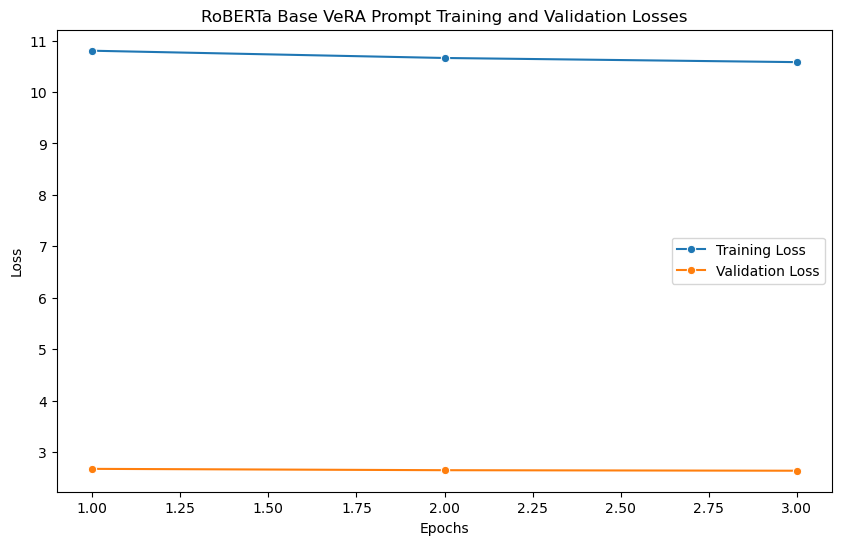

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = range(1, EPOCHS+1)
train_losses = history_roberta_base_prompt_vera['train_loss']
print(train_losses)
val_losses = history_roberta_base_prompt_vera['val_loss']

plt.figure(figsize=(10, 6))

sns.lineplot(x=epochs, y=train_losses, label='Training Loss',marker="o")
sns.lineplot(x=epochs, y=val_losses, label='Validation Loss',marker="o")

plt.title('RoBERTa Base VeRA Prompt Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./roberta-base-prompt-vera-training-validation-losses.png',dpi=780)
plt.show()

In [ ]:
epochs = range(1, EPOCHS+1)
train_accuracies = [tens.item() for tens in history_roberta_base_prompt_vera['train_acc']]
val_accuracies = [tens.item() for tens in history_roberta_base_prompt_vera['val_acc']]

plt.figure(figsize=(10, 6))

sns.lineplot(x=epochs, y=train_accuracies, label='Training accuracy',marker='o')
sns.lineplot(x=epochs, y=val_accuracies, label='Validation accuracy',marker='o')

plt.title('RoBERTa Base VeRA Prompt Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./roberta-base-prompt-vera-training-validation-accuracies.png',dpi=780)
plt.show()

AttributeError: 'float' object has no attribute 'item'

In [ ]:
from transformers.trainer_utils import PredictionOutput
from sklearn.metrics import confusion_matrix,classification_report

def get_predictions(trainer, test_dataset):
    # Runs prediction
    output: PredictionOutput = trainer.predict(test_dataset)

    # Get raw logits and labels
    logits = torch.tensor(output.predictions)
    probs = F.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    labels = torch.tensor(output.label_ids)

    return preds, probs, labels

In [ ]:
preds, probs, labels = get_predictions(trainer_prompt_vera, test_dataset)

In [ ]:
torch.save(preds,"./saved_model/roberta_base_prompt_vera_predictions.pt")
torch.save(probs,"./saved_model/roberta_base_prompt_vera_predictions_probs.pt")
torch.save(labels,"./saved_model/roberta_base_prompt_vera_real_values.pt") 

In [ ]:
target_names = ['Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP',
       'Fingerprinting', 'MITM', 'Normal', 'Password', 'Port_Scanning',
       'Ransomware', 'SQL_injection', 'Uploading', 'Vulnerability_scanner',
       'XSS']

In [ ]:
s = set()

In [ ]:
for elt in preds:
  s.add(elt.item())

In [ ]:
actual_considered_classes = [TARGET_LIST[i] for i in s]
actual_considered_classes

In [ ]:
data['Attack_type'].value_counts()

In [ ]:
def show_confusion_matrix(confusion_matrix):

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
    plt.xticks(rotation=90)
    plt.title("RoBERTa Base VeRA Prompt Confusion Matrix")
    plt.ylabel('Real threats')
    plt.xlabel('Predicted threats')
    plt.savefig('./roberta-base-prompt-vera-confusion-matrix.png',dpi=780)
    plt.show()

In [ ]:
print(classification_report(labels,preds,target_names=TARGET_LIST))

In [ ]:
cm = confusion_matrix(labels,preds)
df_cm = pd.DataFrame(cm,index=TARGET_LIST,columns=TARGET_LIST)
show_confusion_matrix(df_cm)

In [ ]:
y_true = labels.cpu().numpy()
y_score = preds.cpu().numpy()